In [519]:
import numpy as np
from numpy.lib.shape_base import row_stack
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform
from skimage.transform import warp
from skimage.filters import gaussian
from numpy.linalg import inv
from numpy.linalg import svd
import imageio as io
import random
DEFAULT_TRANSFORM = ProjectiveTransform


def find_orb(img, n_keypoints = 2000):
    """Find keypoints and their descriptors in image.

    img ((W, H, 3)  np.ndarray) : 3-channel image
    n_keypoints (int) : number of keypoints to find

    Returns:
        (N, 2)  np.ndarray : keypoints
        (N, 256)  np.ndarray, type=np.bool  : descriptors
    """
    # your code here
    #return(ORB(n_keypoints).detect_and_extract(rgb2gray(img)))
    img_gray = rgb2gray(img)
    # Создаем ORB
    orb = ORB(n_keypoints = n_keypoints)
    
    # Определим ключевые точки и вычислим дескрипторы для изображения
    orb.detect_and_extract(img_gray)
    keypoints_new = orb.keypoints # ключевые точки
    descriptors_new = orb.descriptors # дескрипторы
    return(keypoints_new, descriptors_new)


def center_and_normalize_points(points):
    """Center the image points, such that the new coordinate system has its
    origin at the centroid of the image points.

    Normalize the image points, such that the mean distance from the points
    to the origin of the coordinate system is sqrt(2).

    points ((N, 2) np.ndarray) : the coordinates of the image points

    Returns:
        (3, 3) np.ndarray : the transformation matrix to obtain the new points
        (N, 2) np.ndarray : the transformed image points
    """

    pointsh = np.row_stack([points.T, np.ones((points.shape[0]), )])
    matrix = np.zeros((3, 3))

    # Вычислим координаты центра
    C_x = np.mean(pointsh[0])
    C_y = np.mean(pointsh[1])

    # Cдвигаем точку по x,y в начало координат
    C = [pointsh[0] - C_x, pointsh[1] - C_y]
    
    # Вычисляем коэффициент нормировки
    N = np.sqrt(2) / np.mean(np.sqrt(np.square(C[0]) + np.square(C[1])))
    matrix = np.array([
        [N, 0, -N * C_x], 
        [0, N, -N * C_y], 
        [0, 0, 1]])
    
    transform_points = np.transpose(np.dot(matrix, pointsh))[:, :2]
    return(matrix, transform_points)


def find_homography(src_keypoints, dest_keypoints):
    """Estimate homography matrix from two sets of N (4+) corresponding points.
    src_keypoints ((N, 2) np.ndarray) : source coordinates
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates
    Returns:
        ((3, 3) np.ndarray) : homography matrix
    """
    src_matrix, src = center_and_normalize_points(src_keypoints)
    dest_matrix, dest = center_and_normalize_points(dest_keypoints)
    H = np.zeros((3, 3))
    
    # Создадим списки координат x и y для каждой матрицы
    x_src = src[...,0]
    y_src = src[...,1]

    x_dest = dest[...,0]
    y_dest = dest[...,1]
    # Зададим матрицу A и заполним ее
    row = src_keypoints.shape[0] * 2 # умножаем на 2, так как в матрицу входят вектор-стобцы для координат x и y
    col = 9
    A = np.zeros((row, col))

    for i in range(src_keypoints.shape[0]):
        A[i * 2] = np.array([-x_src[i], -y_src[i], -1, 0, 0, 0, (x_dest[i] * x_src[i]), (x_dest[i] * y_src[i]), x_dest[i]])
        A[i * 2 + 1] = np.array([0, 0, 0, -x_src[i], -y_src[i], -1,  y_dest[i] * x_src[i], y_dest[i] * y_src[i], y_dest[i]])

    # Найдем однородное решение с помощью SVD
    u, s, v_t = svd(A)
    h = v_t[v_t.shape[0] - 1]
    H = np.reshape(h, (3, 3))
    result = np.dot(np.dot(inv(dest_matrix), H), src_matrix)
    return result

def ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, max_trials = 1000, residual_threshold = 2, return_matches=False):
    """Match keypoints of 2 images and find ProjectiveTransform using RANSAC algorithm.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    src_descriptors ((N, 256) np.ndarray) : source descriptors
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates
    dest_descriptors ((N, 256) np.ndarray) : destination descriptors
    max_trials (int) : maximum number of iterations for random sample selection.
    residual_threshold (float) : maximum distance for a data point to be classified as an inlier.
    return_matches (bool) : if True function returns matches

    Returns:
        skimage.transform.ProjectiveTransform : transform of source image to destination image
        (Optional)(N, 2) np.ndarray : inliers' indexes of source and destination images
    """
    # your code here
    #print(src_keypoints)
    m = match_descriptors(src_descriptors, dest_descriptors) # первый столбец матрицы m это номера дексрипторов src_descriptors
                                                             # второй столбец матрицы m это номера дексрипторов dest_descriptors
    count_pair = m.shape[0] # кол-во пар
    n = range(count_pair)
    best_count = 0
    best_pair = [0, 0, 0, 0]
    i = 0
    # 1 этап
    while(i < max_trials):
        count = 0
        # (a)
        pair = random.sample(n, 4) # выбираем случайно 4 пары дескрипторов 
        # (b)
        H = find_homography(src_keypoints[m[pair, 0]], dest_keypoints[m[pair, 1]]) # 0 - обозначает,что мы берем номер дескриптора из первого столбца(src_descriptors)
                                                                                   # 1 - обозначает,что мы берем номер дескриптора из первого столбца(dest_descriptors)
        # (c)
        # Преобразовываем координаты src_keypoints
        new_src_keypoints = ProjectiveTransform(H)(src_keypoints[m[..., 0]])
        s = np.sqrt(((new_src_keypoints[..., 0] - dest_keypoints[m[..., 1], 0]) ** 2) + ((new_src_keypoints[..., 1] - dest_keypoints[m[..., 1], 1]) ** 2))
        count = sum(j < residual_threshold for j in s)

        # (d)
        if(count > best_count):
            best_count = count
            best_pair = pair

        i += 1
 
    # 2 этап
    H = find_homography(src_keypoints[m[best_pair, 0]], dest_keypoints[m[best_pair, 1]])
    new_src_keypoints = ProjectiveTransform(H)(src_keypoints[m[..., 0]])
    s = np.sqrt(((new_src_keypoints[..., 0] - dest_keypoints[m[..., 1], 0]) ** 2) + ((new_src_keypoints[..., 1] - dest_keypoints[m[..., 1], 1]) ** 2))
    inlires = m[s < residual_threshold]
    H_inlires = find_homography(src_keypoints[inlires[..., 0]], dest_keypoints[inlires[..., 1]])
    
    if(return_matches == False):
        return(ProjectiveTransform(H_inlires))
    else:
        return(ProjectiveTransform(H_inlires), inlires)


def find_simple_center_warps(forward_transforms):
    """Find transformations that transform each image to plane of the central image.

    forward_transforms (Tuple[N]) : - pairwise transformations

    Returns:
        Tuple[N + 1] : transformations to the plane of central image
    """
    # forward_transforms - результат ransac(предыдущая функция)
    image_count = len(forward_transforms) + 1

    center_index = (image_count - 1) // 2

    result = [None] * image_count
    result[center_index] = DEFAULT_TRANSFORM()
    
    for i in range(center_index + 1, image_count):
        result[i] = result[i - 1] + forward_transforms[i - 1].inverse
    for i in range(center_index - 1, -1, -1):
        result[i] = result[i + 1] + forward_transforms[i]
    return tuple(result)


def get_corners(image_collection, center_warps):
    """Get corners' coordinates after transformation."""
    for img, transform in zip(image_collection, center_warps):
        height, width, _ = img.shape
        corners = np.array([[0, 0],
                            [height, 0],
                            [height, width],
                            [0, width]])

        yield transform(corners)[:, ::-1]


def get_min_max_coords(corners):
    """Get minimum and maximum coordinates of corners."""
    corners = np.concatenate(corners)
    return corners.min(axis=0), corners.max(axis=0)

def get_final_center_warps(image_collection, simple_center_warps):
    """Find final transformations.

        image_collection (Tuple[N]) : list of all images
        simple_center_warps (Tuple[N])  : transformations unadjusted for shift

        Returns:
            Tuple[N] : final transformations
    """
    # your code here
    result = [None] * len(simple_center_warps)
    corners = tuple(get_corners(image_collection, simple_center_warps))
    bound = get_min_max_coords(corners)
    min_c = bound[0][0]
    max_c = bound[0][1]
    matrix = np.array([
        [1, 0, -max_c], 
        [0, 1, -min_c], 
        [0, 0, 1]])
    
    shift = ProjectiveTransform(matrix)
    for i in range(len(simple_center_warps)):
        result[i] = simple_center_warps[i] + shift
    shape = np.array([bound[1][1] - bound[0][1], bound[1][0] - bound[0][0]], dtype=int)
    return(tuple(result), shape)


def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)

def warp_image(image, transform, output_shape):
    """Apply transformation to an image and its mask

    image ((W, H, 3)  np.ndarray) : image for transformation
    transform (skimage.transform.ProjectiveTransform): transformation to apply
    output_shape (int, int) : shape of the final pano

    Returns:
        (W, H, 3)  np.ndarray : warped image
        (W, H)  np.ndarray : warped mask
    """
    # your code here
    new_img = warp(image, rotate_transform_matrix(transform).inverse, output_shape = output_shape)
    mask = np.ones((image.shape[0], image.shape[1]), dtype= "int32")
    new_mask = warp(mask, rotate_transform_matrix(transform).inverse, output_shape = output_shape)
    return(new_img, new_mask)

def merge_pano(image_collection, final_center_warps, output_shape):
    """ Merge the whole panorama
    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano
    Returns:
        (output_shape) np.ndarray: final pano
    """
    result = np.zeros(np.append(output_shape, 3))
    result_mask = np.zeros(output_shape, dtype=np.bool8)

    # your code here
    n = len(image_collection)
    for i in range(n):
        warped_image, mask = warp_image(image_collection[i], final_center_warps[i], output_shape)
        mask = mask.astype(np.bool8)
        result[mask] = warped_image[mask]
    return result


def get_gaussian_pyramid(image, n_layers, sigma = 1):
    """Get Gaussian pyramid.

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Gaussian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Gaussian pyramid

    """
    # your code here
    result = [None] * n_layers
    result[0] = image
    for i in range(1, n_layers):
        result[i] = gaussian(result[i - 1] , sigma) # последовательно размываем изображение
    return result

def get_laplacian_pyramid(image, n_layers = 10, sigma = 1):
    """Get Laplacian pyramid

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Laplacian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Laplacian pyramid
    """
    # your code here
    result = [None] * n_layers
    gauss_img = get_gaussian_pyramid(image, n_layers, sigma)
    for i in range(0, n_layers - 1):
        result[i] = gauss_img[i] - gauss_img[i + 1]
    
    result[n_layers - 1] = gauss_img[n_layers - 1]
    return result


def merge_laplacian_pyramid(laplacian_pyramid):
    """Recreate original image from Laplacian pyramid
    laplacian pyramid: tuple of np.array (h, w, 3)
    Returns:
        np.array (h, w, 3)
    """
    return sum(laplacian_pyramid)


def increase_contrast(image_collection):
    """Increase contrast of the images in collection"""
    result = []

    for img in image_collection:
        img = img.copy()
        for i in range(img.shape[-1]):
            img[:, :, i] -= img[:, :, i].min()
            img[:, :, i] /= img[:, :, i].max()
        result.append(img)

    return result

def gaussian_merge_pano(image_collection, final_center_warps, output_shape, n_layers=4, image_sigma=1, merge_sigma=1):
    """ Merge the whole panorama using Laplacian pyramid
    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano
    n_layers (int) : number of layers in Laplacian pyramid
    image_sigma (int) :  sigma for Gaussian filter for images
    merge_sigma (int) : sigma for Gaussian filter for masks
    Returns:
        (output_shape) np.ndarray: final pano
    """
    # your code here
    image_collection = increase_contrast(image_collection)
    warps_with_masks = [warp_image(img, warp, output_shape) for img, warp in zip(image_collection, final_center_warps)]
    corners = tuple(get_corners(image_collection, final_center_warps))
    result = np.zeros(np.append(output_shape, 3))
    result += warps_with_masks[0][0]
    
    n = len(image_collection)
    for i in range(1, n):
        max_left = int((corners[i - 1][2, 0] + corners[i - 1][3, 0]) / 2)
        min_right = int((corners[i][0, 0] + corners[i][1, 0]) / 2)
        mask = np.zeros(output_shape)
        mask[:, (max_left + min_right) // 2:] = 1
        
        img1_pyr = get_laplacian_pyramid(result, n_layers, image_sigma)
        img2_pyr = get_laplacian_pyramid(warps_with_masks[i][0], n_layers, image_sigma)
        mask_pyr = get_gaussian_pyramid(mask, n_layers, merge_sigma)
        result = np.zeros(result.shape)
        for i in range(n_layers):
            for channel in range(3):
                result[:, :, channel] += img1_pyr[i][:, :, channel] * np.subtract(1, mask_pyr[i])
                result[:, :, channel] += img2_pyr[i][:, :, channel] * mask_pyr[i]
    
    result = np.clip(result, 0, 1)
    return result

def cylindrical_inverse_map(coords, H, W, scale):
    """Function that transform coordinates in the output image
    to their corresponding coordinates in the input image
    according to cylindrical transform.

    Use it in skimage.transform.warp as `inverse_map` argument

    coords ((M, 2) np.ndarray) : coordinates of output image (M == col * row)
    h (int) : height (number of rows) of input image
    w (int) : width (number of cols) of input image
    scale (int or float) : scaling parameter

    Returns:
     (M, 2) np.ndarray : corresponding coordinates of input image (M == col * row) according to cylindrical transform
    """
    # your code here
    K = np.array([[scale, 0, W / 2], [0, scale, H / 2], [0, 0, 1]])

    # 1
    C = np.vstack([coords[:, 0], coords[:, 1], np.ones(coords[:, 0].shape)])
    
    # 2
    K_inv = inv(K)
    C_inv = np.dot(K_inv, C)
    
    # 3
    B_inv = np.vstack([np.tan(C_inv[0]), C_inv[1] / np.cos(C_inv[0]) , np.ones(C_inv[0].shape)])
    
    # 4
    B = np.dot(K, B_inv)
    
    new_coords = np.zeros(coords.shape)
    new_coords[:,0] = B[0]
    new_coords[:,1] = B[1]
    return new_coords

def warp_cylindrical(img, scale = None, crop=True):
    """Warp image to cylindrical coordinates

    img ((H, W, 3)  np.ndarray) : image for transformation
    scale (int or None) : scaling parameter. If None, defaults to W * 0.5
    crop (bool) : crop image to fit (remove unnecessary zero-padding of image)

    Returns:
        (H, W, 3)  np.ndarray : warped image (H and W may differ from original)
    """
    # your code here
    H = img.shape[0]
    W = img.shape[1]
    
    if scale is None:
        scale = W * 0.5
        
    res = warp(img, cylindrical_inverse_map, map_args = {'H': H, 'W': W, 'scale': scale}, output_shape = img.shape)
    
    # Обрезаем картинку
    if(crop == True):
        h_start = 0
        w_start = 0
        h = res.shape[0]
        w = res.shape[1]
        for i in range(h):
            c = res[i, :].sum()
            for i in range(w):
                c = res[:, i].sum()
                if(c == 0):
                    w_start = i
                else:
                    break
            if(c == 0):
                h_start = i
            else:
                break
                
        for i in range(res.shape[0]-1, -1, -1):
            c = res[i, :].sum()
            for i in range(res.shape[1]-1, -1, -1):
                c = res[:, i].sum()
                if(c == 0):
                    w = i
                else:
                    break
            if(c == 0):
                h = i
            else:
                break
                
        new_image = res[h_start : h, w_start : w, :]
        return new_image
    else:
        return res

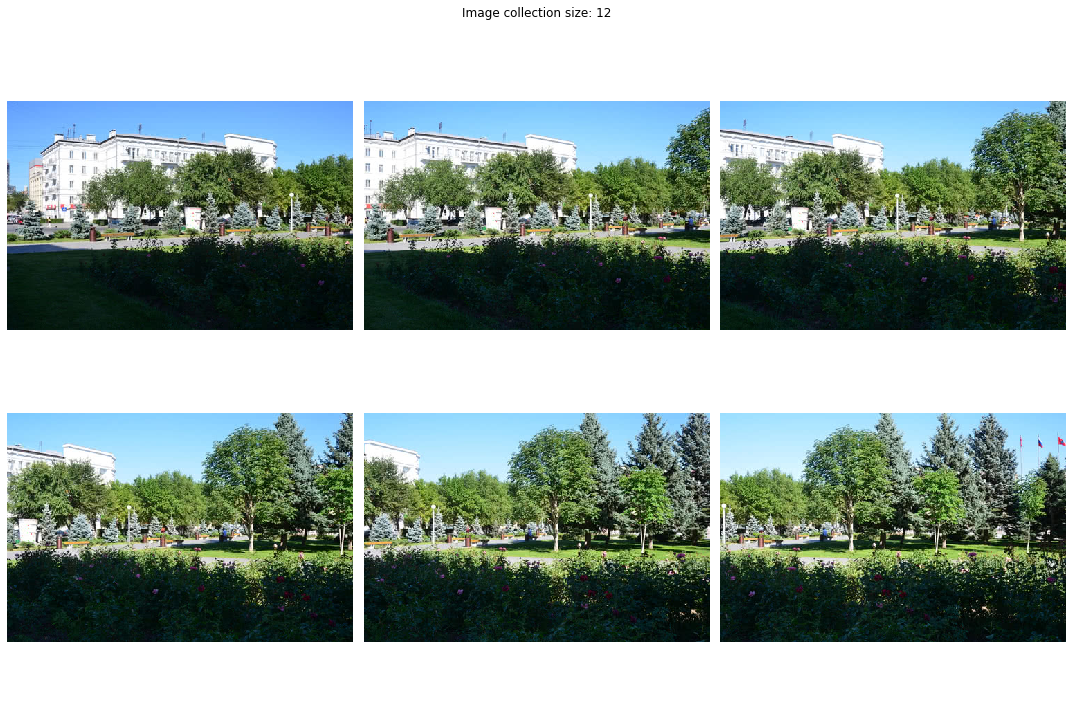

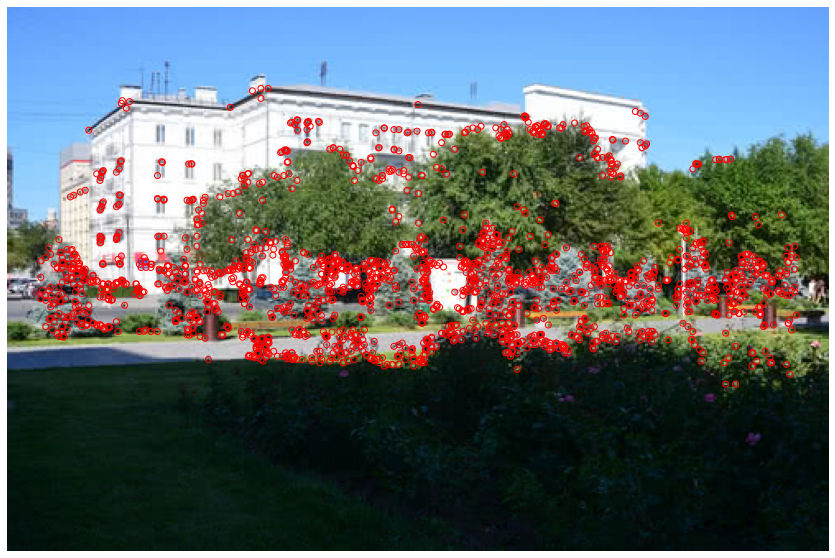

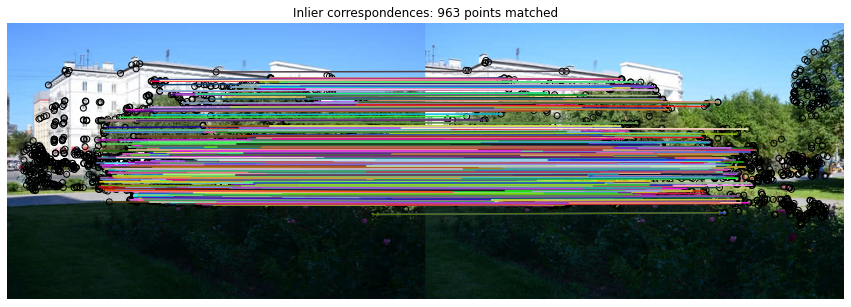

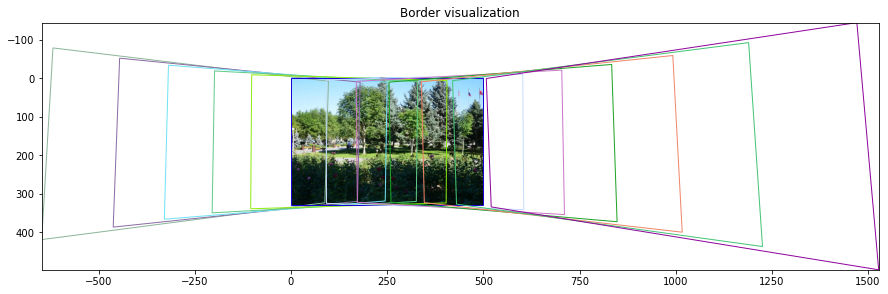

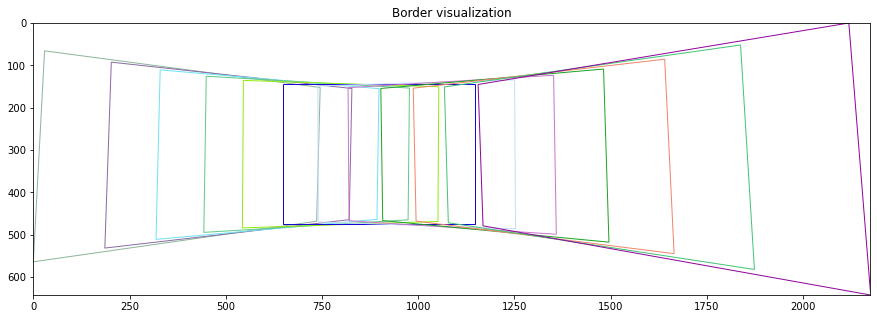

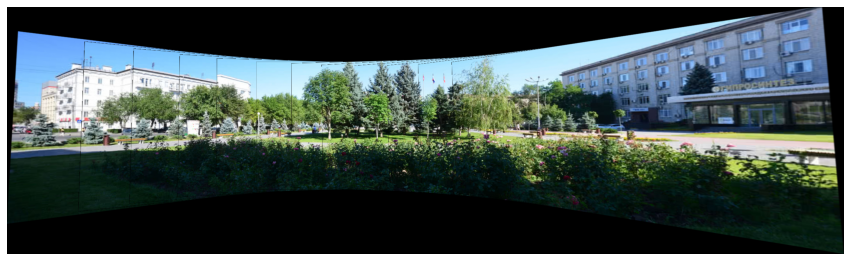

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-519-46917e97b3a9>:288: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  result[i] = gaussian(result[i - 1] , sigma) # последовательно размываем изображение
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


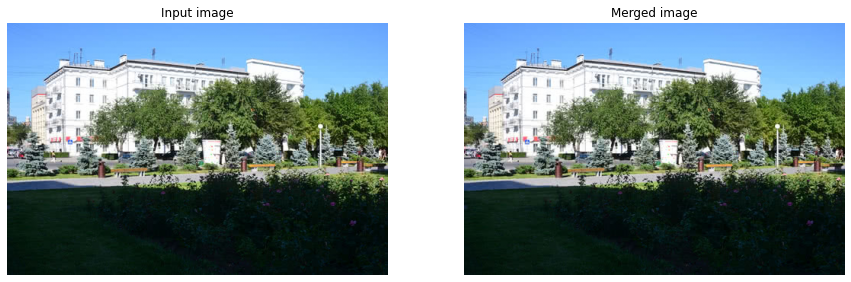

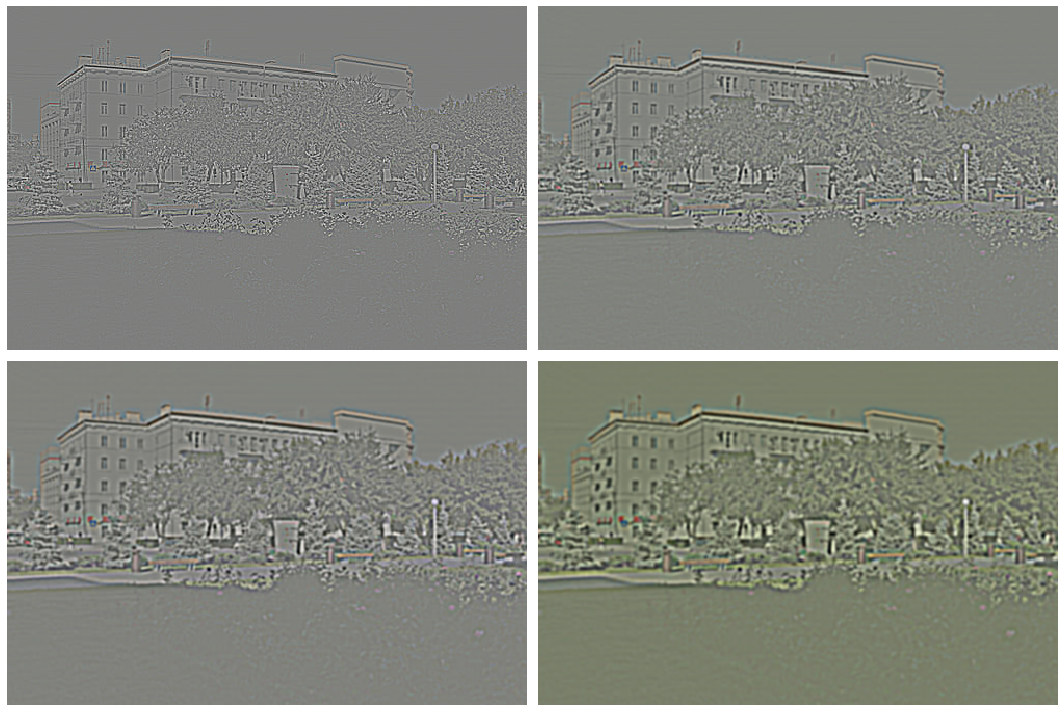

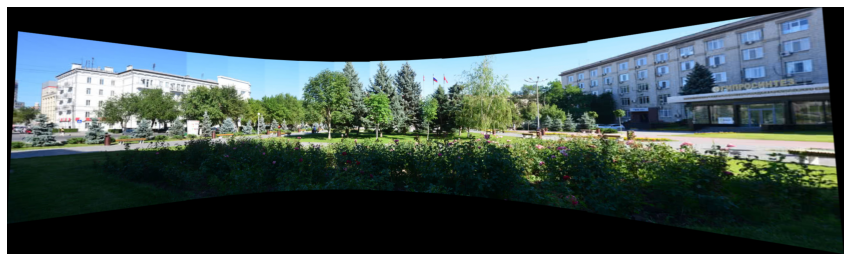

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


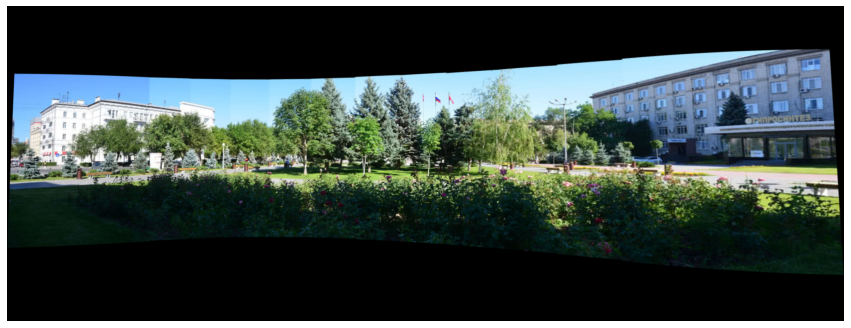

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [520]:
#!/usr/bin/env python3

from skimage import io
import numpy as np

# ------------------------------------------------------------------------------------------
# Part 0
# ------------------------------------------------------------------------------------------

pano_image_collection = io.ImageCollection('imgs/00/8_*.jpg',
                                           load_func=lambda f: io.imread(f).astype(np.float64) / 255)
plot_collage(pano_image_collection, title=f"Image collection size: {len(pano_image_collection)}")


# ------------------------------------------------------------------------------------------
# Part 1
# ------------------------------------------------------------------------------------------

img = pano_image_collection[0]
keypoints, descriptors = find_orb(img)

plot_keypoints(img, keypoints)


# ------------------------------------------------------------------------------------------
# Part 2 and 3
# ------------------------------------------------------------------------------------------

src, dest = pano_image_collection[0], pano_image_collection[1]
src_keypoints, src_descriptors = find_orb(src)
dest_keypoints, dest_descriptors = find_orb(dest)

robust_transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

plot_inliers(src, dest, src_keypoints, dest_keypoints, matches)


# ------------------------------------------------------------------------------------------
# Part 4
# ------------------------------------------------------------------------------------------

keypoints, descriptors = zip(*(find_orb(img) for img in pano_image_collection))
forward_transforms = tuple(ransac_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))


simple_center_warps = find_simple_center_warps(forward_transforms)
corners = tuple(get_corners(pano_image_collection, simple_center_warps))
min_coords, max_coords = get_min_max_coords(corners)
center_img = pano_image_collection[(len(pano_image_collection) - 1) // 2]

plot_warps(corners, min_coords=min_coords, max_coords=max_coords, img=center_img)


final_center_warps, output_shape = get_final_center_warps(pano_image_collection, simple_center_warps)
corners = tuple(get_corners(pano_image_collection, final_center_warps))

plot_warps(corners, output_shape=output_shape)

# # ------------------------------------------------------------------------------------------
# # Part 5
# # ------------------------------------------------------------------------------------------

result = merge_pano(pano_image_collection, final_center_warps, output_shape)

plot_result(result)
io.imsave('./results/base_pano.jpeg', result)

# # ------------------------------------------------------------------------------------------
# # Part 6
# # ------------------------------------------------------------------------------------------

img = pano_image_collection[0]

laplacian_pyramid = get_laplacian_pyramid(img)
merged_img = merge_laplacian_pyramid(laplacian_pyramid)

plot_gauss(img, merged_img)
plot_collage(increase_contrast(laplacian_pyramid), columns=2, rows=2)

result = gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)

plot_result(result)
io.imsave('./results/improved_pano.jpeg', result)

# ------------------------------------------------------------------------------------------
# Part 7
# ------------------------------------------------------------------------------------------

cylindrical = warp_cylindrical(result)

plot_result(cylindrical)
io.imsave('./results/cylindrical_pano.jpeg', cylindrical)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from skimage.feature import plot_matches

FIGSIZE = (15, 10)
COLUMNS = 3
ROWS = 2


def plot_collage(imgs, columns=COLUMNS, rows=ROWS, figsize=FIGSIZE, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
        plt.axis('off')

    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i - 1], interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def plot_keypoints(img, keypoints):
    plt.figure(figsize=FIGSIZE)
    plt.imshow(img)
    plt.axis('off')
    plt.scatter(keypoints[:, 1], keypoints[:, 0], facecolors='none', edgecolors='r')
    plt.show()


def plot_inliers(src, dest, src_keypoints, dest_keypoints, matches):
    plt.figure(figsize=FIGSIZE)
    ax = plt.axes()
    ax.axis("off")
    ax.set_title(f"Inlier correspondences: {len(matches)} points matched")
    plot_matches(ax, src, dest, src_keypoints, dest_keypoints,
                 matches)
    plt.show()


def plot_warps(corners, output_shape=None, min_coords=None, max_coords=None, img=None):
    np.random.seed(0)
    if output_shape is None:
        plt.figure(figsize=FIGSIZE)
    else:
        plt.figure(figsize=(15, 5))
    ax = plt.axes()

    for coords in corners:
        ax.add_patch(Polygon(coords, closed=True, fill=False, color=np.random.rand(3)))

    if max_coords is not None:
        plt.xlim(min_coords[0], max_coords[0])
        plt.ylim(max_coords[1], min_coords[1])

    if output_shape is not None:
        plt.xlim(0, output_shape[1])
        plt.ylim(output_shape[0], 0)

    if img is not None:
        plt.imshow(img)

    plt.title('Border visualization')
    plt.show()


def plot_gauss(img, merged_img):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input image')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title('Merged image')
    plt.axis('off')
    plt.imshow(merged_img)
    plt.show()


def plot_result(result):
    plt.figure(figsize=FIGSIZE)
    plt.imshow(result)
    plt.axis('off')
    plt.show()
